#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/cba.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df.iloc[:-1,:]
df.tail()   
#df.info()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
5743,27/07/2022,96.510002,99.370003,96.459999,98.900002,98.900002,2221207,1.35,2.5,125.0
5744,28/07/2022,99.480003,100.199997,99.110001,99.889999,99.889999,3301364,1.35,2.5,125.0
5745,29/07/2022,100.300003,101.364998,100.099998,100.769997,100.769997,3122636,1.35,2.5,125.0
5746,1/08/2022,100.680000,101.080002,99.089996,101.080002,101.080002,2374671,1.35,2.5,125.0
5747,2/08/2022,100.989998,102.269997,100.430000,101.970001,101.970001,1905527,1.35,2.5,125.0


In [3]:
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

# # Drop all previous records now in MongoDb
# db.cba.drop()
# # Insert all the records in the CSV into MongoDb
# records=df.to_dict('records')
# records
# db.cba.insert_many(records)	

In [4]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.cba.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.cba.delete_one(
    {'Date': last_date}
)


DELETE: 29/08/2022 96.27999877929688


In [5]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.cba.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Previous last date in MongoDb: "+last_date+". Today's date: "+today)

NEW LAST VALUE IN MONGODB: 26/08/2022 98.30999755859375
Previous last date in MongoDb: 26-08-2022. Today's date: 01-09-2022


In [6]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'CBA.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
#remove last date already in mongodb
stock_quote=stock_quote.iloc[1:]

stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-29,96.739998,95.620003,96.529999,96.279999,2107747,96.279999
2022-08-30,97.309998,96.320000,96.410004,96.550003,1833997,96.550003
2022-08-31,97.470001,96.050003,96.559998,97.470001,2822535,97.470001


In [7]:
tot=len(stock_quote)
rba=1.85
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)

#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)

stock_quote

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,29/08/2022,96.739998,95.620003,96.529999,96.279999,2107747,96.279999,1.85,2.5,125
1,30/08/2022,97.309998,96.320000,96.410004,96.550003,1833997,96.550003,1.85,2.5,125
2,31/08/2022,97.470001,96.050003,96.559998,97.470001,2822535,97.470001,1.85,2.5,125


In [8]:
records=stock_quote.to_dict('records')
records

[{'Date': '29/08/2022',
  'High': 96.73999786376953,
  'Low': 95.62000274658203,
  'Open': 96.52999877929688,
  'Close': 96.27999877929688,
  'Volume': 2107747,
  'Adj Close': 96.27999877929688,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '30/08/2022',
  'High': 97.30999755859375,
  'Low': 96.31999969482422,
  'Open': 96.41000366210938,
  'Close': 96.55000305175781,
  'Volume': 1833997,
  'Adj Close': 96.55000305175781,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '31/08/2022',
  'High': 97.47000122070312,
  'Low': 96.05000305175781,
  'Open': 96.55999755859375,
  'Close': 97.47000122070312,
  'Volume': 2822535,
  'Adj Close': 97.47000122070312,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125}]

In [9]:
#INSERT NEW DATA INTO MONGODB
db.cba.insert_many(records)

#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.cba.find()))

last_val = df_mongo.iloc[-10:].values
print(last_val)

[[ObjectId('62ff3da9bdef3be3a47272ce') '18/08/2022' 99.97000122070312
  101.08999633789062 99.68000030517578 100.98999786376953
  100.98999786376953 2811590.0 1.85 2.5 125.0]
 [ObjectId('630332eaab52de7a273eaf9e') '19/08/2022' 101.05000305175781
  101.0999984741211 99.55000305175781 99.94999694824219 99.94999694824219
  3405681.0 1.85 2.5 125.0]
 [ObjectId('6304a3bee39fe6902a0db143') '22/08/2022' 99.30999755859375
  99.80000305175781 98.80999755859375 98.95999908447266 98.95999908447266
  1796830.0 1.85 2.5 125.0]
 [ObjectId('630729f84421cf05cf7c7ec9') '23/08/2022' 98.5
  98.68499755859375 97.0199966430664 97.0199966430664 97.0199966430664
  2354382.0 1.85 2.5 125.0]
 [ObjectId('630729f84421cf05cf7c7eca') '24/08/2022' 97.25
  98.02999877929688 97.16000366210938 97.19999694824219 97.19999694824219
  2155170.0 1.85 2.5 125.0]
 [ObjectId('630ae5b27f69fdbf1a91ce60') '25/08/2022' 97.52999877929688
  98.05000305175781 96.6500015258789 97.81999969482422 97.81999969482422
  1706595.0 1.85 2.5 

In [10]:
#Save latest to variables
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_date,last_close)

31/08/2022 97.47000122070312


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [11]:
df_mongo = pd.DataFrame(list(db.cba.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(5769, 1)

In [12]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape

In [13]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4616, 1)

In [14]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.04184307, 0.03844119, 0.03186422, 0.02619443, 0.02902934,
       0.03583307, 0.03112717, 0.0329982 , 0.03073027, 0.03450637,
       0.0379876 , 0.03712579, 0.03129727, 0.03469913, 0.03390536,
       0.03469913, 0.0329982 , 0.0329982 , 0.03776081, 0.04218326,
       0.04036892, 0.03544755, 0.03531146, 0.03016329, 0.03424555,
       0.03549291, 0.03408679, 0.03696705, 0.04090187, 0.0449728 ,
       0.04610676, 0.05227547, 0.04921377, 0.04036892, 0.04110597,
       0.03708043, 0.0399607 , 0.04127609, 0.03932567, 0.03889476,
       0.03056017, 0.02780467, 0.03696705, 0.03526612, 0.03062821,
       0.02789536, 0.0244935 , 0.0244935 , 0.0244935 , 0.00521622,
       0.00657697, 0.00635016, 0.01099939, 0.0086521 , 0.00521622,
       0.00510283, 0.00147414, 0.00136076, 0.00011341, 0.00100922])]
[0.002086477591719982]


# Prepare train data for LSTM model

In [15]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4556, 60)

In [16]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4556, 60, 1)

# Build the LSTM model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [18]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4556/4556 [==============================] - 313s 67ms/step - loss: 7.9382e-04


In [20]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [21]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [22]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [23]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.1507402447411304

In [24]:
# date_time = df["Date"]
# date_time = pd.to_datetime(date_time)
# data = data.set_index(date_time)

C:\Users\antoi\AppData\Local\Temp/ipykernel_14784/2404096143.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


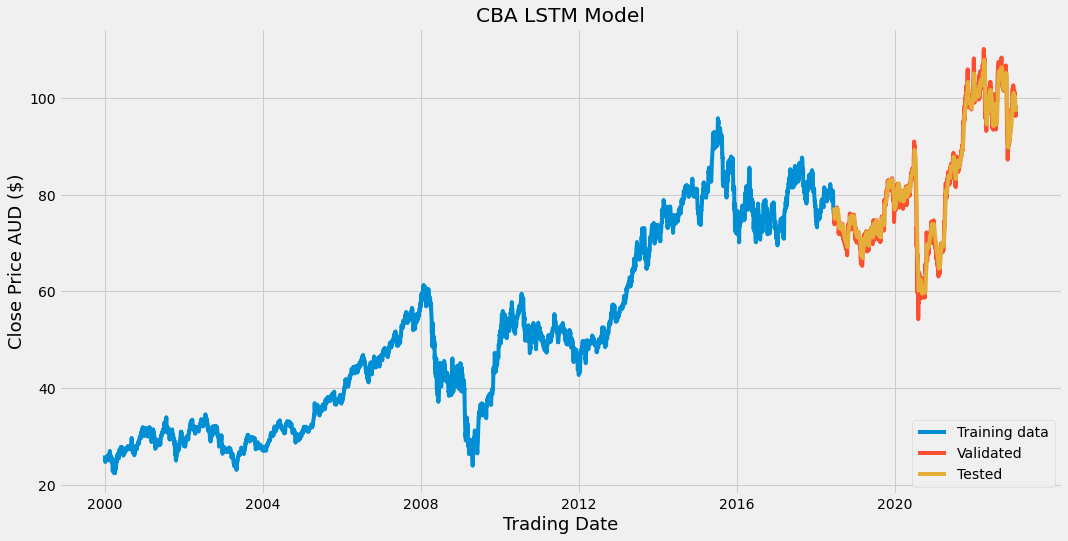

In [25]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('CBA LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training data','Validated','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/cba_graph.png')
plt.show()

# Test data Predictions on the Model

In [26]:
valid['Difference']= valid['Close']-valid['Predictions']
valid.head

C:\Users\antoi\AppData\Local\Temp/ipykernel_14784/3403988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


<bound method NDFrame.head of           Close  Predictions  Difference
4616  76.300003    77.357994   -1.057991
4617  73.980003    77.100601   -3.120598
4618  73.860001    76.453644   -2.593643
4619  74.019997    75.825607   -1.805610
4620  74.400002    75.374008   -0.974006
...         ...          ...         ...
5764  97.820000    98.256874   -0.436874
5765  98.309998    97.933311    0.376686
5766  96.279999    97.882011   -1.602013
5767  96.550003    97.454369   -0.904366
5768  97.470001    97.111214    0.358788

[1153 rows x 3 columns]>

In [27]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.cba.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [28]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [29]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price),2)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

31/08/2022 Last close $97.47000122070312 Predicted next day share price $96.38


# Save the Model

In [30]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/cba_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list cba_sixty and load df

In [31]:
#PREDICT USING LOADED MODEL
from keras.models import load_model
model_in = load_model('../static/cba_model.sav')

In [32]:
# query the cba collection and load into dataframe

df_mongo = pd.DataFrame(list(db.cba.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[ 97.470001  ],
       [ 92.699997  ],
       [ 93.699997  ],
       [ 88.440002  ],
       [ 89.940002  ],
       [ 90.        ],
       [ 86.980003  ],
       [ 87.419998  ],
       [ 87.980003  ],
       [ 89.120003  ],
       [ 89.480003  ],
       [ 88.790001  ],
       [ 91.459999  ],
       [ 93.099998  ],
       [ 92.230003  ],
       [ 90.379997  ],
       [ 90.209999  ],
       [ 91.239998  ],
       [ 90.580002  ],
       [ 90.309998  ],
       [ 91.580002  ],
       [ 92.379997  ],
       [ 92.160004  ],
       [ 92.449997  ],
       [ 93.089996  ],
       [ 93.059998  ],
       [ 91.349998  ],
       [ 92.989998  ],
       [ 93.730003  ],
       [ 95.5       ],
       [ 95.440002  ],
       [ 96.900002  ],
       [ 96.849998  ],
       [ 96.43      ],
       [ 96.459999  ],
       [ 99.110001  ],
       [100.099998  ],
       [ 99.089996  ],
       [100.43000031],
       [100.23999786],
       [100.87000275],
       [101.12999725],
       [101.02999878],
       [100

In [33]:
from keras.models import load_model
model_in = load_model('../static/cba_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_cba(last_sixty,model_in,input):
    for i in range(0, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred=predict_cba(last_sixty,model_in,input)
price_pred

0
Day finished! Price: 
1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day fin

[96.63,
 96.59,
 96.61,
 96.65,
 96.68,
 96.72,
 96.75,
 96.78,
 96.81,
 96.84,
 96.86,
 96.88,
 96.9,
 96.92,
 96.94,
 96.96,
 96.98,
 97.0,
 97.01,
 97.03,
 97.05,
 97.06,
 97.08,
 97.09,
 97.11,
 97.13,
 97.14,
 97.15,
 97.16,
 97.16,
 97.16,
 97.17,
 97.18,
 97.18,
 97.19,
 97.2,
 97.2,
 97.21,
 97.22,
 97.22,
 97.23,
 97.24,
 97.24,
 97.25,
 97.26,
 97.26,
 97.27,
 97.28,
 97.29,
 97.29,
 97.3,
 97.3,
 97.31,
 97.29,
 97.29,
 97.29,
 97.29,
 97.27,
 97.27,
 97.27,
 97.27,
 97.27,
 97.27,
 97.27,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26,
 97.26

In [34]:
import pandas as pd
from datetime import date,datetime,timedelta
today1 = date.today()
count=[]
dates=[]
dow=[]
row=0
for x in range(1,293,1): 
  d=today1+timedelta(days=x)
  a=d.strftime("%A")
  if a != "Saturday" and a != "Sunday":
     dates.append(d.strftime('%d-%m-%Y'))
     dow.append(a)
     row=row+1
     count.append(row)

data = {'Count': count,
        'Date': dates,
        'DOW': dow
        }
dates_df = pd.DataFrame(data)
print (dates_df.tail)

<bound method NDFrame.tail of      Count        Date        DOW
0        1  02-09-2022     Friday
1        2  05-09-2022     Monday
2        3  06-09-2022    Tuesday
3        4  07-09-2022  Wednesday
4        5  08-09-2022   Thursday
..     ...         ...        ...
203    204  14-06-2023  Wednesday
204    205  15-06-2023   Thursday
205    206  16-06-2023     Friday
206    207  19-06-2023     Monday
207    208  20-06-2023    Tuesday

[208 rows x 3 columns]>


In [35]:
#UPDATE DATES IN MONGODB AND CHECK IF UPDATED ALEADY
today4 = date.today()
d=today4+timedelta(days=1)
d=d.strftime('%d-%m-%Y')
print("Today plus one day:   "+d)
#Check if mongoDb now has latest data
dates_df = pd.DataFrame(list(db.dates.find()))
d_mdb = dates_df.iloc[0,2]
print("Predicted next date in mongodb:   "+d_mdb)
# print(d,d_mdb)

def update_date():
    # Drop all previous records now in MongoDb
    db.dates.drop()
    records=dates_df.to_dict('records')

    #INSERT NEW DATA INTO MONGODB
    db.dates.insert_many(records)

    #Check if mongoDb now has latest data
    dates_mongo = pd.DataFrame(list(db.dates.find()))
    dates_updated = dates_mongo.iloc[:,1:].values
    return dates_updated

if d==d_mdb:
    print("Awesome! dates are already correctly updated!")
else:
    print("Dates need to be updated"+d+"  "+d_mdb)
    dates_updated = update_date()
    print(dates_updated)

Today plus one day:   02-09-2022
Predicted next date in mongodb:   02-09-2022
Awesome! dates are already correctly updated!


C:\Users\antoi\AppData\Local\Temp/ipykernel_14784/4262353664.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


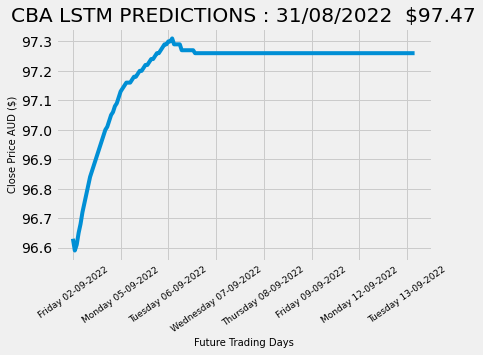

In [36]:
# DRAW THE PREDICTION
day1=dates_df.iloc[0,3]+" "+dates_df.iloc[0,2]
day2=dates_df.iloc[1,3]+" "+dates_df.iloc[1,2]
day3=dates_df.iloc[2,3]+" "+dates_df.iloc[2,2]
day4=dates_df.iloc[3,3]+" "+dates_df.iloc[3,2]
day5=dates_df.iloc[4,3]+" "+dates_df.iloc[4,2]
day6=dates_df.iloc[5,3]+" "+dates_df.iloc[5,2]
day7=dates_df.iloc[6,3]+" "+dates_df.iloc[6,2]
day8=dates_df.iloc[7,3]+" "+dates_df.iloc[7,2]
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:input]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('CBA LSTM PREDICTIONS : '+last_date+"  $"+str(round(last_close,2)))
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.xticks([0,25,50,75,100,125,150,175],[day1,day2,day3,day4,day5,day6,day7,day8],fontsize=9,rotation=35)
plt.savefig('../static/data/images/pred/cba_pred.png', bbox_inches="tight")
plt.show()


In [37]:
my_dict = dates_df_iloc.to_dict(orient='records')
my_dict
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
price_dict

[{'Price': 96.63},
 {'Price': 96.59},
 {'Price': 96.61},
 {'Price': 96.65},
 {'Price': 96.68},
 {'Price': 96.72},
 {'Price': 96.75},
 {'Price': 96.78},
 {'Price': 96.81},
 {'Price': 96.84},
 {'Price': 96.86},
 {'Price': 96.88},
 {'Price': 96.9},
 {'Price': 96.92},
 {'Price': 96.94},
 {'Price': 96.96},
 {'Price': 96.98},
 {'Price': 97.0},
 {'Price': 97.01},
 {'Price': 97.03},
 {'Price': 97.05},
 {'Price': 97.06},
 {'Price': 97.08},
 {'Price': 97.09},
 {'Price': 97.11},
 {'Price': 97.13},
 {'Price': 97.14},
 {'Price': 97.15},
 {'Price': 97.16},
 {'Price': 97.16},
 {'Price': 97.16},
 {'Price': 97.17},
 {'Price': 97.18},
 {'Price': 97.18},
 {'Price': 97.19},
 {'Price': 97.2},
 {'Price': 97.2},
 {'Price': 97.21},
 {'Price': 97.22},
 {'Price': 97.22},
 {'Price': 97.23},
 {'Price': 97.24},
 {'Price': 97.24},
 {'Price': 97.25},
 {'Price': 97.26},
 {'Price': 97.26},
 {'Price': 97.27},
 {'Price': 97.28},
 {'Price': 97.29},
 {'Price': 97.29},
 {'Price': 97.3},
 {'Price': 97.3},
 {'Price': 97.31},

In [38]:

# df_len = len(df.index) # length of the original dataframe
len_df_mongo=len(df_mongo)
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,len_df_mongo,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)

4616 5769 5928


,Close
5918,97.26
5919,97.26
5920,97.26
5921,97.26
5922,97.26
5923,97.26
5924,97.26
5925,97.26
5926,97.26
5927,97.26


C:\Users\antoi\AppData\Local\Temp/ipykernel_14784/2732492008.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


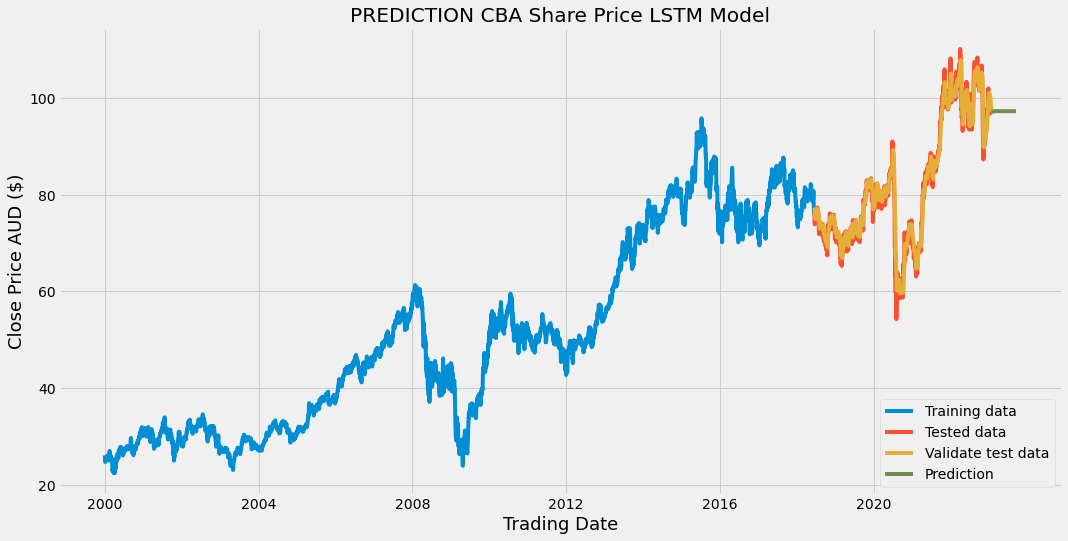

In [39]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION CBA Share Price LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/cba_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [40]:
# Query all
name = 'CBA'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f869a32d48e159f9650d6b'), 'model': 'RFR', 'name': 'CBA', 'date': '12/08/2022', 'predicted': 97, 'actual': 100, 'difference': -2.7336, 'accuracy': 97.42}
{'_id': ObjectId('630dc693de01e11621c50261'), 'model': 'LSTM', 'name': 'CBA', 'date': '30/08/2022', 'predicted': 95.74, 'actual': 96.55, 'difference': -0.81, 'rmse': 0.5768}


In [41]:
# Delete a document from a collection
db.companys_agg.delete_one(
    {'model': 'LSTM','name': name,'date':last_date}
)
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': 'CBA'})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f869a32d48e159f9650d6b'), 'model': 'RFR', 'name': 'CBA', 'date': '12/08/2022', 'predicted': 97, 'actual': 100, 'difference': -2.7336, 'accuracy': 97.42}


In [42]:
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_date}, predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 31/08/2022, predicted $96.38, actual $97.47, difference -1.0900000000000034, rmse 0.15074


In [43]:
# Insert a document into the 'companys' collection
db.companys_agg.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62f869a32d48e159f9650d6b'), 'model': 'RFR', 'name': 'CBA', 'date': '12/08/2022', 'predicted': 97, 'actual': 100, 'difference': -2.7336, 'accuracy': 97.42}
{'_id': ObjectId('630ffb2e5f450fe375e22e0d'), 'model': 'LSTM', 'name': 'CBA', 'date': '31/08/2022', 'predicted': 96.38, 'actual': 97.47, 'difference': -1.09, 'rmse': 0.15074}


In [44]:
# query all the classroom collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '29/07/2022', 'predicted': 44, 'actual': 38, 'difference': 6.9125, 'accuracy': 97.16}
{'_id': ObjectId('62e63809b66c4b7fa3db1a22'), 'model': 'RFR', 'name': 'anz', 'date': '29/07/2022', 'predicted': 33, 'actual': 22, 'difference': 11.1838, 'accuracy': 97.09}
{'_id': ObjectId('62ea3a74d27bca6473865515'), 'model': 'RFR', 'name': 'bhp', 'date': '02/08/2022', 'predicted'